In [1]:
import argparse
from statistics import mean, stdev
from time import perf_counter

import torch
from torch.nn.functional import linear

from graphesn import DynamicGraphReservoir, initializer, Readout
from graphesn.util import compute_dynamic_graph_alpha, compute_dynamic_weighted_graph_alpha
from stocks_loader import *


def prepare_stocks_data(device, weighted=False, lags=1):
    data = stocks_dataset(feature_mode=None, target_offset=lags).to(device)
    alpha = compute_dynamic_weighted_graph_alpha(data) if weighted else compute_dynamic_graph_alpha(data)
    
    return data.edge_index, data.edge_weight if weighted else None, data.x, data.y, alpha, data.num_timesteps

In [12]:
args_dict = {
    'units': 32,
    'device' : 'cuda',
    'sigma' : 0.9,
    'leakage' : 0.9,
    'ld' : [1e-3],
    'trials' : 20    
}

device = torch.device(args_dict['device'])
edge_index, edge_weight, x, y, alpha, T = prepare_stocks_data(device=device)
T_train, T_valid = int(T * 0.8), int(T * 0.9)
print(f'alpha = {alpha:.2f}')

train_time, train_mse, test_time, test_mse = [], [], [], []


def validate_on(weights, Xval, yval):
    return torch.mean((linear(Xval, weights[0], weights[1]) - yval) ** 2)

for _ in range(args_dict['trials']):
    reservoir = DynamicGraphReservoir(num_layers=1, in_features=x.shape[-1], hidden_features=args_dict['units'], return_sequences=True)
    reservoir.initialize_parameters(recurrent=initializer('uniform', sigma=args_dict['sigma'] / alpha),
                                    input=initializer('uniform', scale=1),
                                    leakage=args_dict['leakage'])
    reservoir.to(device)
    readout = Readout(num_features=args_dict['units'], num_targets=10)

    tic = perf_counter()
    
    X = reservoir(edge_index=edge_index[:T_valid] if isinstance(edge_index, list) else edge_index, input=x[:T_valid])
    readout.fit(data=(X[:T_train].view(-1, X.shape[-1]), y[:T_train].view(-1, y.shape[-1])), regularization=args_dict['ld'],
                validate=lambda weights: validate_on(weights, X[T_train:T_valid].view(-1, X.shape[-1]), y[T_train:T_valid].view(-1, y.shape[-1])))
    
    toc = perf_counter()
    
    y_hat_train = readout(X[:T_train].view(-1, X.shape[-1]))
    mse_loss = torch.mean(( y_hat_train - y[:T_train].view(-1, y.shape[-1])) ** 2)
    train_mse.append(mse_loss.item())
    train_time.append((toc - tic) * 1000)

    tic = perf_counter()
    
    X = reservoir(edge_index=edge_index, input=x)
    y_hat = readout(X[T_valid:].view(-1, X.shape[-1]))
    
    mse_loss = torch.mean((y_hat - y[T_valid:].view(-1, y.shape[-1])) ** 2)
    toc = perf_counter()
    
    test_mse.append(mse_loss.item())
    test_time.append((toc - tic) * 1000)


alpha = 3.88


In [13]:
print(f'{mean(train_mse):.3f} ± {stdev(train_mse):.3f}',
      f'{mean(test_mse):.3f} ± {stdev(test_mse):.3f}',
      f'{mean(train_time):.5f} ± {stdev(train_time):.5f}',
      f'{mean(test_time):.5f} ± {stdev(test_time):.5f}',
      sep='\t')

0.058 ± 0.043	0.559 ± 0.480	14.21110 ± 0.93762	15.16434 ± 0.72469


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

Text(0, 0.5, 'MSE loss')

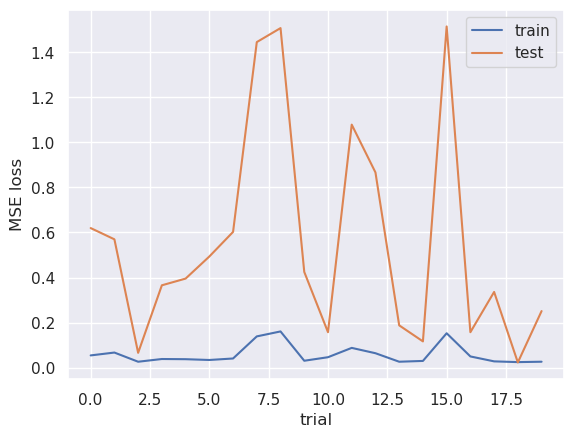

In [22]:
plt.plot(train_mse, label='train')
plt.plot(test_mse, label='test')
plt.legend()
plt.xlabel('trial')
plt.ylabel('MSE loss')

Text(0.5, 1.0, 'Training')

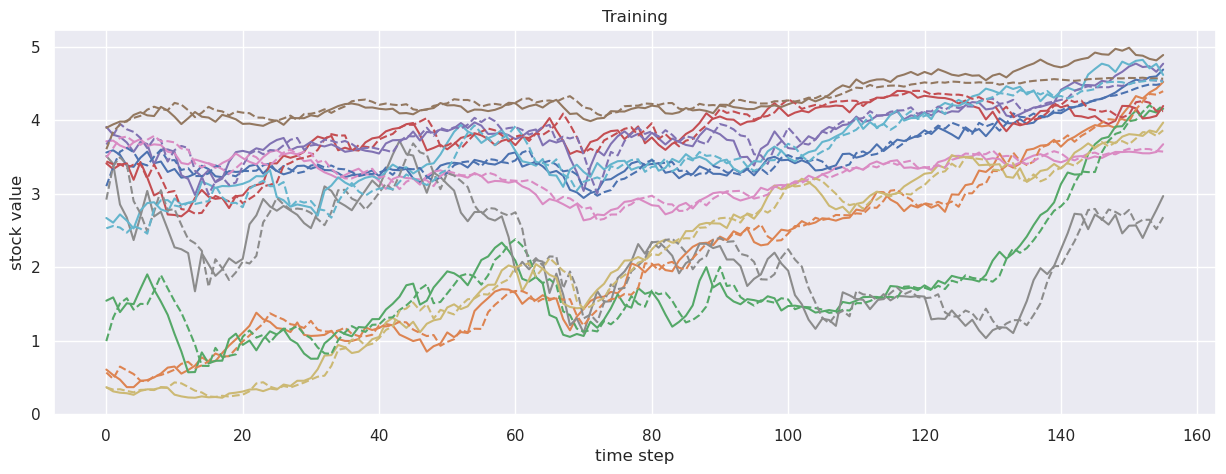

In [23]:
# Train
s = y[:T_train].shape[0]

Y_PRED = y_hat_train.reshape((s,10))
Y_TARGET = y[:T_train].reshape((s,10))

plt.figure(figsize=(15,5))
plt.plot(Y_TARGET.detach().cpu(), label='target')
plt.plot(Y_PRED.detach().cpu(), '--', label='forecast')
plt.xlabel('time step')
plt.ylabel('stock value')
plt.title('Training')


Text(0.5, 1.0, 'Testing')

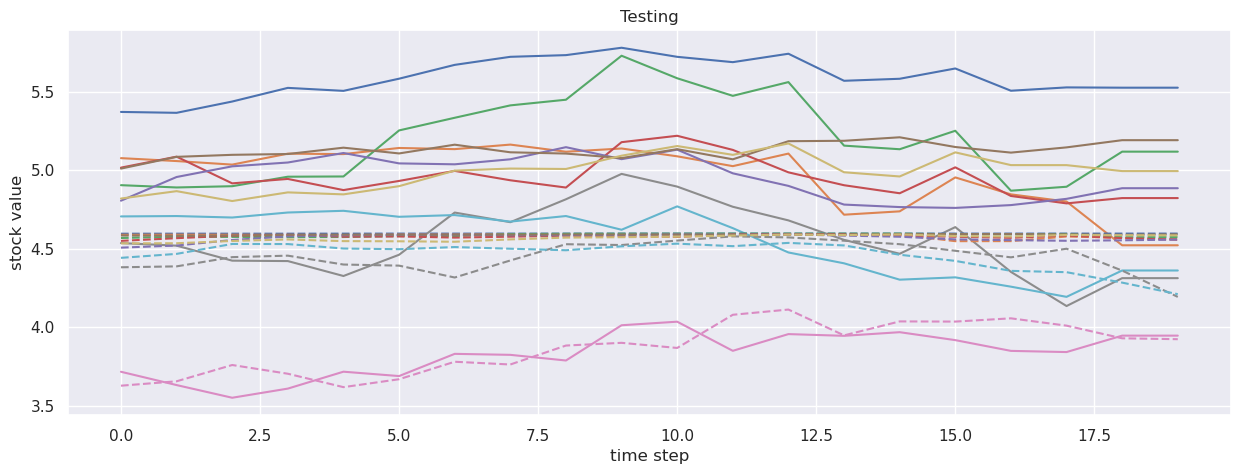

In [24]:
# Test
s = y[T_valid:].shape[0]

Y_PRED = y_hat.reshape((s,10))
Y_TARGET = y[T_valid:].reshape((s,10))

plt.figure(figsize=(15,5))
plt.plot(Y_TARGET.detach().cpu(), label='target')
plt.plot(Y_PRED.detach().cpu(), '--', label='forecast')
plt.xlabel('time step')
plt.ylabel('stock value')
plt.title('Testing')
